In [329]:
import numpy as np
import pandas as pd
import random
from nltk.corpus import brown
import string
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
import math 

In [330]:
brown_sents = brown.sents()

## Use this for shorter runtime
# brown_sents = brown.sents(categories='news')

### Data processing

In [331]:
# Pre-processing
brown_sents = np.array(brown_sents)
for i, sent in enumerate(brown_sents):
    new_sent = [''.join(char for char in word if char not in string.punctuation) for word in sent]
    brown_sents[i] = [word.lower() for word in new_sent if word]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [332]:
# Split corpus into 20 subcorpora by dividing sentences randomly
random.shuffle(brown_sents)
split = np.array_split(brown_sents, 20)

In [333]:
# Divide subcorpora in ranks and frequency corpora
ranks = split[:10]
freqs = split[10:]

In [334]:
# Join rank sentences together
for i, j in enumerate(ranks):
    ranks[i] = [item for sublist in j for item in sublist]

# Join frequency sentences together
for i, j in enumerate(freqs):
    freqs[i] = [item for sublist in j for item in sublist]

### Calculating the ranks

In [335]:
# For each rank subcorpus, create frequency dictionary from which ranks will be estimated
freqs_dicts_1 = {}
for i, j in enumerate(ranks):
    dict_i = {}
    for word in j:
        if word not in dict_i:
            dict_i[word] = 1
        else:
            dict_i[word] += 1
    freqs_dicts_1[i] = dict_i

In [336]:
# For each rank subcorpus, calculate ranks and put in dictionary
ranks_dicts = {}
for i in freqs_dicts_1:
    i_dict = freqs_dicts_1[i]
    ranked = {key: rank for rank, key in enumerate(sorted(i_dict, key=i_dict.get, reverse=True), 1)}
    ranks_dicts[i] = ranked

In [337]:
# Calculate average ranks
ranks_df = pd.DataFrame(ranks_dicts)
mean_ranks = ranks_df.mean(axis=1)

### Calculating the frequencies

In [338]:
# For each frequency subcorpus, create frequency dictionary
freqs_dicts_2 = {}
for i, j in enumerate(freqs):
    dict_i = {}
    for word in j:
        if word not in dict_i:
            dict_i[word] = 1
        else:
            dict_i[word] += 1
    freqs_dicts_2[i] = dict_i

In [339]:
# Calculate average frequencies
freqs_df = pd.DataFrame(freqs_dicts_2)
mean_freqs = freqs_df.mean(axis=1)

### Estimating Zipf's law

We estimate Zipf's law using $f(w) \propto \frac{1}{r(w)^{\alpha}}$. In the following code block, the $\alpha$ is found using maximum likelihood estimation, for which the code was taken from https://stats.stackexchange.com/questions/6780/how-to-calculate-zipfs-law-coefficient-from-a-set-of-top-frequencies .

In [340]:
df = pd.concat([mean_ranks, mean_freqs], axis=1, sort=False)
df.set_axis(["Rank", "Frequency"], axis=1, inplace=True)
df = df.sort_values(by=['Rank'])

In [341]:
# Estimate the alpha parameter 
def loglikelihood(a):  
    # Power law function
    Probabilities = df['Rank']**(-a)

    # Normalized
    Probabilities = Probabilities/Probabilities.sum()

    # Log Likelihoood
    Lvector = np.log(Probabilities)

    # Multiply the vector by frequencies
    Lvector = np.log(Probabilities) * df['Frequency']

    # LL is the sum
    L = Lvector.sum()

    # We want to maximize LogLikelihood or minimize (-1)*LogLikelihood
    return(-L)

alpha = minimize(loglikelihood, [0.9]).x

In [342]:
df['Estimated frequency'] = max(df['Frequency'])/df['Rank']**alpha

### Results

In [343]:
df.head(10)

,Rank,Frequency,Estimated frequency
the,1.0,3516.4,3516.400000
of,2.0,1841.4,1783.019860
and,3.0,1469.8,1198.467103
to,4.0,1312.3,904.095046
a,5.0,1162.6,726.547385
in,6.0,1067.9,607.692710
that,7.3,538.6,501.458378
is,8.5,505.8,431.991822
was,9.7,496.5,379.561886
for,9.9,468.7,372.047497


In [344]:
# Take logs
df_log = np.log(df)
df_log.set_axis(["Rank (log)", "Frequency (log)", "Estimated frequency (log)"], axis=1, inplace=True)

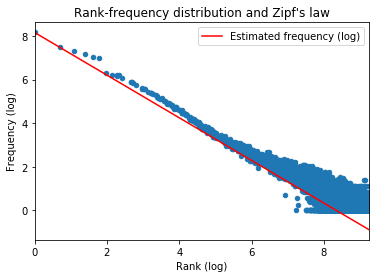

In [345]:
ax = df_log.plot(x ='Rank (log)', y='Frequency (log)', kind = 'scatter')
df_log.plot(x ='Rank (log)', y='Estimated frequency (log)', kind = 'line', ax=ax, color='red')
plt.title("Rank-frequency distribution and Zipf's law")
plt.show()

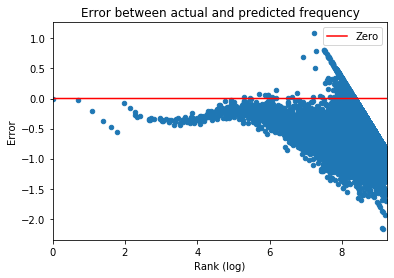

In [346]:
df_log['Error'] = df_log['Estimated frequency (log)'] - df_log['Frequency (log)']
df_log['Zero'] = 0
ax = df_log.plot(x ='Rank (log)', y='Error', kind = 'scatter')
df_log.plot(x ='Rank (log)', y = 'Zero', kind = 'line', ax=ax, color='red')
# plt.ylim([-1, 1])
plt.title("Error between actual and predicted frequency")
plt.show()

# Dealing with NaNs

### Option 1: remove NaNs

In [347]:
df_1 = pd.concat([mean_ranks, mean_freqs], axis=1, sort=False)
df_1.set_axis(["Rank", "Frequency"], axis=1, inplace=True)
df_1 = df_1.sort_values(by=['Rank'])
df_1.dropna(subset = ["Rank"], inplace=True)
df_1.dropna(subset = ["Frequency"], inplace=True)

In [349]:
# Estimate the alpha parameter 
def loglikelihood(a):  
    # Power law function
    Probabilities = df_1['Rank']**(-a)

    # Normalized
    Probabilities = Probabilities/Probabilities.sum()

    # Log Likelihoood
    Lvector = np.log(Probabilities)

    # Multiply the vector by frequencies
    Lvector = np.log(Probabilities) * df_1['Frequency']

    # LL is the sum
    L = Lvector.sum()

    # We want to maximize LogLikelihood or minimize (-1)*LogLikelihood
    return(-L)

alpha_1 = minimize(loglikelihood, [0.9]).x

In [350]:
df_1['Predicted frequency'] = max(df_1['Frequency'])/(df_1['Rank']**alpha_1)
df_1_log = np.log(df_1)
df_1_log.set_axis(["Rank (log)", "Frequency (log)", "Estimated frequency (log)"], axis=1, inplace=True)

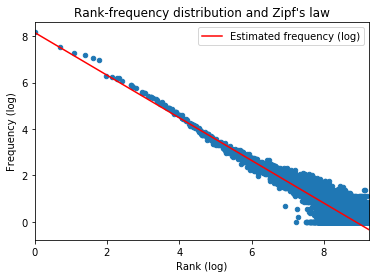

In [351]:
ax = df_1_log.plot(x ='Rank (log)', y='Frequency (log)', kind = 'scatter')
df_1_log.plot(x ='Rank (log)', y='Estimated frequency (log)', kind = 'line', ax=ax, color='red')
plt.title("Rank-frequency distribution and Zipf's law")
plt.show()

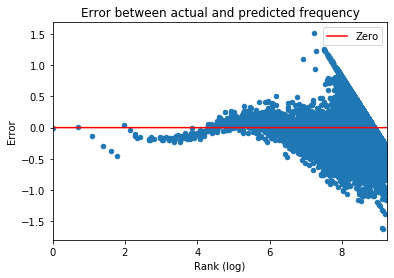

In [352]:
df_1_log['Error'] = df_1_log['Estimated frequency (log)'] - df_1_log['Frequency (log)']
df_1_log['Zero'] = 0
ax = df_1_log.plot(x ='Rank (log)', y='Error', kind = 'scatter')
df_1_log.plot(x ='Rank (log)', y = 'Zero', kind = 'line', ax=ax, color='red')
# plt.ylim([-1, 1])
plt.title("Error between actual and predicted frequency")
plt.show()

### Option 2: replace NaN's

In [353]:
df_2 = pd.concat([mean_ranks, mean_freqs], axis=1, sort=False)
df_2.set_axis(["Rank", "Frequency"], axis=1, inplace=True)
df_2 = df_2.sort_values(by=['Rank'])
df_2

,Rank,Frequency
the,1.0,3516.4
of,2.0,1841.4
and,3.0,1469.8
to,4.0,1312.3
a,5.0,1162.6
...,...,...
observances,NaN,1.0
stillbuilding,NaN,1.0
londonbased,NaN,1.0
192829,NaN,1.0


In [354]:
df_2['Frequency'] = df_2['Frequency'].replace(np.nan, 0)
df_2.dropna(subset = ["Rank"], inplace=True)

In [355]:
# Estimate the alpha parameter 
def loglikelihood(a):  
    # Power law function
    Probabilities = df_2['Rank']**(-a)

    # Normalized
    Probabilities = Probabilities/Probabilities.sum()

    # Log Likelihoood
    Lvector = np.log(Probabilities)

    # Multiply the vector by frequencies
    Lvector = np.log(Probabilities) * df_2['Frequency']

    # LL is the sum
    L = Lvector.sum()

    # We want to maximize LogLikelihood or minimize (-1)*LogLikelihood
    return(-L)

alpha_2 = minimize(loglikelihood, [0.9]).x

In [359]:
# Log(0) gives -inf, so this has to be solved
df_2['Predicted frequency'] = max(df_2['Frequency'])/(df_2['Rank']**alpha_2)
df_2_log = np.log(df_2)
df_2_log.set_axis(["Rank (log)", "Frequency (log)", "Estimated frequency (log)"], axis=1, inplace=True)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [360]:
df_2_log

,Rank (log),Frequency (log),Estimated frequency (log)
the,0.000000,8.165193,8.165193
of,0.693147,7.518281,7.486064
and,1.098612,7.292882,7.088799
to,1.386294,7.179537,6.806934
a,1.609438,7.058414,6.588304
...,...,...,...
teeming,9.255983,-inf,-0.903601
nationstates,9.256365,-inf,-0.903975
hale,9.256556,0.000000,-0.904162
proliferated,9.257033,-inf,-0.904630


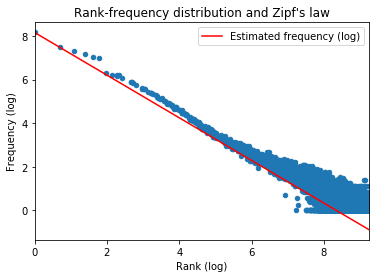

In [361]:
ax = df_2_log.plot(x ='Rank (log)', y='Frequency (log)', kind = 'scatter')
df_2_log.plot(x ='Rank (log)', y='Estimated frequency (log)', kind = 'line', ax=ax, color='red')
plt.title("Rank-frequency distribution and Zipf's law")
plt.show()